# Bank Customer Churn Analysis and Modeling Notebook 

🟦 CELL 0 — Notebook Setup

In [22]:
import warnings
warnings.filterwarnings("ignore")


🟦 CELL 1 — Imports

In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    classification_report,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import pickle
import os


🟦 CELL 2 — Load Preprocessed Data

In [24]:
DATA_PATH = "/workspaces/Bank-Customer-Data-Prep/data/Bank_Churn_Preprocessed.csv"
df = pd.read_csv(DATA_PATH)

display(Markdown("### Dataset Loaded"))
display(df.head())


### Dataset Loaded

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,ProductPerYear,balance_to_income,income_v_product,Gender_num
0,15690738,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.500,0.000000,50674.440000,1
1,15690738,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1.000,0.744670,56271.290000,1
2,15690738,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.375,1.401362,28482.892500,1
3,15690738,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2.000,0.000000,31275.543333,1
4,15690738,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.500,1.587035,39542.050000,1


🟦 CELL 3 — Drop Non-Model Columns

In [25]:
DROP_COLS = ['CustomerId', 'Surname', 'Gender', 'Geography']
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

df_model = df.drop(columns=DROP_COLS)

display(Markdown("### Columns Used for Modeling"))
display(df_model.columns.to_list())


### Columns Used for Modeling

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'ProductPerYear',
 'balance_to_income',
 'income_v_product',
 'Gender_num']

🟦 CELL 4 — Define Features & Target

In [26]:
FEATURES = [
    'CreditScore','Gender_num','Age','Tenure','Balance','NumOfProducts',
    'HasCrCard','IsActiveMember','EstimatedSalary',
    'ProductPerYear','balance_to_income','income_v_product'
]

X = df_model[FEATURES]
y = df_model['Exited']

display(Markdown(f"**Feature count:** {X.shape[1]}"))


**Feature count:** 12

🟦 CELL 5 — Train / Test Split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

display(Markdown("### Train / Test Split"))
display(Markdown(f"Train rows: {x_train.shape[0]}"))
display(Markdown(f"Test rows: {x_test.shape[0]}"))


### Train / Test Split

Train rows: 8000

Test rows: 2000

🟦 CELL 6 — Feature Scaling 

In [28]:
scaler = StandardScaler()

x_train_scaled = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns=x_train.columns,
    index=x_train.index
)

x_test_scaled = pd.DataFrame(
    scaler.transform(x_test),
    columns=x_test.columns,
    index=x_test.index
)


🟦 CELL 7 — Random Forest Model (Anti-Overfitting)

In [29]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=25,
    min_samples_split=40,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=25, min_samples_split=40,
                       n_estimators=300, n_jobs=-1, random_state=42)

🟦 CELL 8 — Cross-Validation (Generalization Check)

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf,
    x_train_scaled,
    y_train,
    cv=cv,
    scoring="roc_auc"
)

display(Markdown(f"### CV ROC-AUC: **{cv_scores.mean():.4f}**"))


### CV ROC-AUC: **0.8410**

🟦 CELL 9 — Test Performance

In [31]:
y_test_proba = rf.predict_proba(x_test_scaled)[:,1]
test_auc = roc_auc_score(y_test, y_test_proba)

display(Markdown(f"### Test ROC-AUC: **{test_auc:.4f}**"))


### Test ROC-AUC: **0.8483**

🟦 CELL 10 — ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


🟦 CELL 11 — Overfitting Check (Train vs Test)

In [32]:
train_auc = roc_auc_score(
    y_train,
    rf.predict_proba(x_train_scaled)[:,1]
)

auc_gap = train_auc - test_auc

display(Markdown(f"**Train AUC:** {train_auc:.4f}"))
display(Markdown(f"**Test AUC:** {test_auc:.4f}"))
display(Markdown(f"**AUC Gap:** {auc_gap:.4f}"))

if auc_gap > 0.05:
    display(Markdown("⚠️ Possible overfitting"))
else:
    display(Markdown("✅ Good generalization"))


**Train AUC:** 0.8881

**Test AUC:** 0.8483

**AUC Gap:** 0.0398

✅ Good generalization

🟦 CELL 12 — Feature Importance

,Importance
Age,0.398016
NumOfProducts,0.226638
IsActiveMember,0.068200
Balance,0.062517
balance_to_income,0.053758
income_v_product,0.051292
ProductPerYear,0.033882
EstimatedSalary,0.031565
CreditScore,0.030428
Gender_num,0.023053


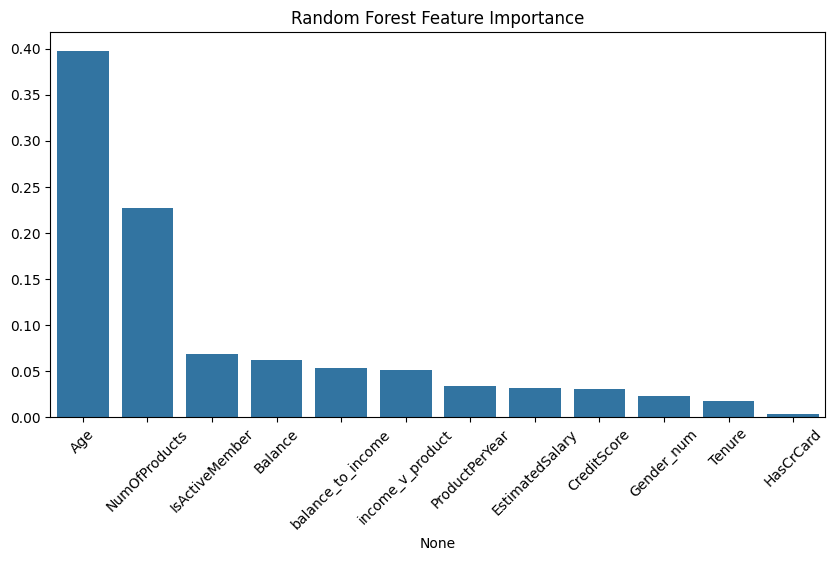

In [33]:
feat_imp = pd.Series(
    rf.feature_importances_,
    index=x_train.columns
).sort_values(ascending=False)

display(feat_imp.to_frame("Importance").style.bar(color="#4CAF50"))

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.index, y=feat_imp.values)
plt.xticks(rotation=45)
plt.title("Random Forest Feature Importance")
plt.show()


🟦 CELL 13 — Optimal Threshold (F1-Score)

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

display(Markdown(f"### Best Threshold (F1-Optimized): **{best_threshold:.4f}**"))


### Best Threshold (F1-Optimized): **0.5789**

🟦 CELL 14 — Save Model Artifacts

In [35]:
BASE_PATH = "/workspaces/Bank-Customer-Data-Prep/models"
os.makedirs(BASE_PATH, exist_ok=True)

with open(f"{BASE_PATH}/churn_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open(f"{BASE_PATH}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open(f"{BASE_PATH}/threshold.pkl", "wb") as f:
    pickle.dump(best_threshold, f)

display(Markdown("✅ Model, scaler, and threshold saved"))


✅ Model, scaler, and threshold saved

🟦 CELL 15 — Load Artifacts (Inference Mode)

In [36]:
with open(f"{BASE_PATH}/churn_model.pkl", "rb") as f:
    model = pickle.load(f)

with open(f"{BASE_PATH}/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open(f"{BASE_PATH}/threshold.pkl", "rb") as f:
    best_threshold = pickle.load(f)


🟦 CELL 16 — Unified Prediction Function (FINAL)

In [37]:
REQUIRED_FEATURES = FEATURES.copy()

def get_predictions(input_df: pd.DataFrame) -> pd.Series:
    df = input_df.copy()

    if 'Gender_num' not in df.columns and 'Gender' in df.columns:
        df['Gender_num'] = np.where(
            df['Gender'].astype(str).str.title() == 'Female', 1, 0
        )

    df['ProductPerYear'] = df['NumOfProducts'] / (df['Tenure'] + 0.1)
    df['balance_to_income'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['income_v_product'] = df['EstimatedSalary'] / (df['NumOfProducts'] + 1)

    for col in REQUIRED_FEATURES:
        if col not in df.columns:
            df[col] = 0

    X = df[REQUIRED_FEATURES]
    X_scaled = scaler.transform(X)

    return pd.Series(
        model.predict_proba(X_scaled)[:,1],
        index=df.index,
        name="Churn Probability"
    )


🟦 CELL 17 — Single Customer Test

In [38]:
sample_customer = pd.DataFrame([{
    'CreditScore': 650,
    'Gender': 'Female',
    'Age': 45,
    'Tenure': 3,
    'Balance': 50000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 60000
}])

sample_customer['Churn Probability'] = get_predictions(sample_customer)
sample_customer['Verdict'] = np.where(
    sample_customer['Churn Probability'] >= best_threshold,
    "🔴 HIGH RISK",
    "🟢 LOW RISK"
)

display(sample_customer)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn Probability,Verdict
0,650,Female,45,3,50000,2,1,1,60000,0.479964,🟢 LOW RISK


📦 DEPLOYMENT NOTEBOOK 

🟢 CELL 0 — Imports & Environment Check

In [39]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import os
import pickle
import joblib
import sklearn

display(Markdown("## 🚀 Deployment Notebook Started"))
display(Markdown(f"**scikit-learn version:** `{sklearn.__version__}`"))


## 🚀 Deployment Notebook Started

**scikit-learn version:** `1.5.0`

🟢 CELL 1 — Load Model, Scaler & Threshold (RUN FIRST)

In [40]:
MODEL_PATH = "/workspaces/Bank-Customer-Data-Prep/churn_model.pkl"
SCALER_PATH = "/workspaces/Bank-Customer-Data-Prep/scaler.pkl"
THRESHOLD_PATH = "/workspaces/Bank-Customer-Data-Prep/threshold.pkl"

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

best_threshold = joblib.load(THRESHOLD_PATH)

display(Markdown("✅ Model, scaler, and threshold loaded successfully"))
display(Markdown(f"**Optimal Threshold:** `{best_threshold:.4f}`"))


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/Bank-Customer-Data-Prep/threshold.pkl'

🟢 CELL 2 — Define REQUIRED_FEATURES (Single Source of Truth)

In [ ]:
REQUIRED_FEATURES = [
    'CreditScore','Gender_num','Age','Tenure','Balance','NumOfProducts',
    'HasCrCard','IsActiveMember','EstimatedSalary',
    'ProductPerYear','balance_to_income','income_v_product'
]

display(Markdown("### 📌 Required Model Features"))
display(REQUIRED_FEATURES)


🟢 CELL 3 — Unified Prediction Function 

In [ ]:
def get_predictions(input_df: pd.DataFrame) -> pd.Series:
    df = input_df.copy()

    # Encode Gender
    if 'Gender_num' not in df.columns and 'Gender' in df.columns:
        df['Gender_num'] = np.where(
            df['Gender'].astype(str).str.title() == 'Female', 1, 0
        )

    # Feature Engineering
    df['ProductPerYear'] = df['NumOfProducts'] / (df['Tenure'] + 0.1)
    df['balance_to_income'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['income_v_product'] = df['EstimatedSalary'] / (df['NumOfProducts'] + 1)

    # Ensure all required columns exist
    for col in REQUIRED_FEATURES:
        if col not in df.columns:
            df[col] = 0

    X = df[REQUIRED_FEATURES]
    X_scaled = scaler.transform(X)

    probs = model.predict_proba(X_scaled)[:, 1]
    return pd.Series(probs, index=df.index, name="Churn Probability")


🟢 CELL 4 — Single Customer Prediction Test

In [ ]:
single_customer = pd.DataFrame([{
    'CreditScore': 650,
    'Gender': 'Female',
    'Age': 45,
    'Tenure': 3,
    'Balance': 50000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 60000,
    'Geography': 'France'
}])

single_customer['Churn Probability'] = get_predictions(single_customer)

single_customer['Verdict'] = np.where(
    single_customer['Churn Probability'] > best_threshold,
    "🔴 HIGH RISK",
    "🟢 LOW RISK"
)

display(Markdown("### 🎯 Single Customer Prediction"))
display(single_customer[['Age','Balance','Churn Probability','Verdict']].style.format({
    'Churn Probability': '{:.2%}',
    'Balance': '${:,.2f}'
}))


🟢 CELL 5 — Batch Prediction Test (Simulation)

In [ ]:
# Simulate batch input (replace with real app input later)
batch_customers = pd.DataFrame([
    {'CreditScore':720,'Gender':'Male','Age':30,'Tenure':5,'Balance':0,
     'NumOfProducts':1,'HasCrCard':1,'IsActiveMember':1,'EstimatedSalary':70000},
    {'CreditScore':580,'Gender':'Female','Age':52,'Tenure':2,'Balance':120000,
     'NumOfProducts':2,'HasCrCard':0,'IsActiveMember':0,'EstimatedSalary':40000},
])

batch_probs = get_predictions(batch_customers)
batch_customers['Churn Probability'] = batch_probs
batch_customers['Verdict'] = np.where(
    batch_probs > best_threshold,
    "🔴 HIGH RISK",
    "🟢 LOW RISK"
)

display(Markdown("### 📦 Batch Prediction Results"))
display(batch_customers.style.format({'Churn Probability':'{:.2%}'}))


🟢 CELL 6 — Final Deployment Sanity Check

In [ ]:
assert hasattr(model, "predict_proba"), "❌ Model not loaded correctly"
assert hasattr(scaler, "transform"), "❌ Scaler not loaded correctly"
assert isinstance(best_threshold, float), "❌ Threshold invalid"

display(Markdown("### ✅ Deployment Sanity Check Passed"))
display(Markdown("This notebook is production-ready."))
